# MNIST classification using PyTorch

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os

In [7]:
MNIST_path = 'data/'

In [8]:
if not os.path.exists(MNIST_path):
    os.makedirs(MNIST_path)

In [9]:
# The MNIST dataset
Transform = transforms.ToTensor()
train = datasets.MNIST(MNIST_path, train=True, download=False, transform=Transform)
print(train)

test = datasets.MNIST(MNIST_path, train=False, download=False, transform=Transform)
print(test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()


In [10]:
ID = 0
image, label = train[ID]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


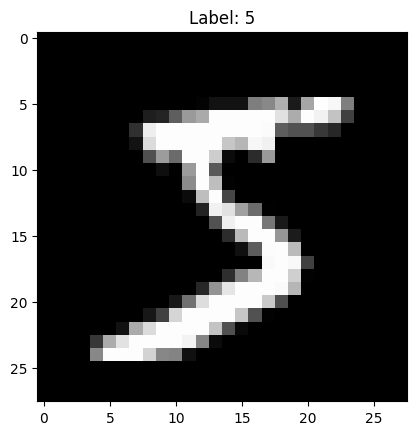

In [11]:
# plt.imshow(image.reshape((28,28)), cmap='gray')
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Label: {label}')
# plt.axis('off')
plt.show()

In [12]:
# Prep batch processing
batch_size_train = 2500
batch_size_test = 1250

# Set-up loaders
train_loader = DataLoader(train, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size_test, shuffle=False)
#Setting shuffle to True means that the dataset will be shuffled after each epoch.

## Setting up the neural network ##

In [13]:
lay1 = 128 #nodes in hidden layer 1
lay2 = 64 #nodes in hidden layer 2

# Defining the neural network
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size=784, output_size=10, layers=[lay1,lay2]):
        super().__init__()
        self.d1 = nn.Linear(input_size, layers[0]) # hidden layer 1
        self.d2 = nn.Linear(layers[0], layers[1]) # hidden layer 2
        self.d3 = nn.Linear(layers[1], output_size) # output layer

    def forward(self, x):
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        x = self.d3(x)
        return F.log_softmax(x, dim=1)
model = MultilayerPerceptron()
print(model)

MultilayerPerceptron(
  (d1): Linear(in_features=784, out_features=128, bias=True)
  (d2): Linear(in_features=128, out_features=64, bias=True)
  (d3): Linear(in_features=64, out_features=10, bias=True)
)


### Calculate the number of trainable parameters

In [14]:
# Calculating the number of trainable parameters in the MLP

## --- Define the number of params between each layer --- ##

# Input layer to hidden layer 1 
N1 = 784 * lay1 + lay1 #[connections + biases]

# Hidden 1 to Hidden 2
N2 = 128 * lay2 + lay2 #[connections + biases]

# Hidden 2 to Output layer
N3 = 64 * 10 + 10 #[connections + biases]

## ----------------------------------------------------- ##

# Total number of parameters
print('Trainable parameters: ' + str(N1 + N2 + N3))

Trainable parameters: 109386


### Specify the loss function and optimizer

In [15]:
# Loss function and optimizer
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Run the training and testing

In [18]:
# Epochs
epochs = 25 # Epoch is one pass of all training data
# Preparation:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) #send model/MLP to GPU if available
print(device)
# Wallclock
start_time = datetime.now()
current_time = start_time.strftime("%H:%M:%S")
print('Network training start time = ', current_time)
# Train the network
train_losses = []
train_correct = []
test_losses = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    for index, (x_train, y_train) in enumerate(train_loader):
        index+=1
        # Apply model
        y_pred = model(x_train.to(device).view(batch_size_train,-1))
        loss = criterion(y_pred, y_train.to(device))
        # Calculate number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train.to(device)).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad() #reset gradients after each training step
        loss.backward() #trigger backpropagation
        optimizer.step()

         # Print interim results
        if index%(60000/batch_size_train) == 0:
            print(f'epoch: {i:2} , Train loss: {loss.item():10.8f} , Train accuracy: {trn_corr.item()*100/60000:4.2f}')
    # Update train loss and accuracy for the epoch
    train_losses.append(loss.item())
    train_correct.append(trn_corr.cpu())
    # Run testing batches
    with torch.no_grad():
        for index, (x_test, y_test) in enumerate(test_loader):
            # Apply model
            y_val = model(x_test.to(device).view(batch_size_test,-1))

             # Tally Correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test.to(device)).sum()
    # Update test loss and accuracy for the epoch
    loss = criterion(y_val, y_test.to(device))
    test_losses.append(loss.cpu())
    test_correct.append(tst_corr.cpu())
# Print final accuracy
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%')

# Wallclock
timestampEnd = datetime.now()
currentTime = timestampEnd.strftime("%H:%M:%S")
print('Network training end time = ', currentTime)

cuda
Network training start time =  10:25:59
epoch:  0 , Train loss: 0.31813601 , Train accuracy: 80.77
epoch:  1 , Train loss: 0.17129973 , Train accuracy: 92.87
epoch:  2 , Train loss: 0.16043797 , Train accuracy: 95.08
epoch:  3 , Train loss: 0.12800977 , Train accuracy: 96.28
epoch:  4 , Train loss: 0.11788522 , Train accuracy: 97.03
epoch:  5 , Train loss: 0.08328286 , Train accuracy: 97.51
epoch:  6 , Train loss: 0.06555258 , Train accuracy: 98.01
epoch:  7 , Train loss: 0.05410967 , Train accuracy: 98.24
epoch:  8 , Train loss: 0.04292607 , Train accuracy: 98.53
epoch:  9 , Train loss: 0.04527289 , Train accuracy: 98.78
epoch: 10 , Train loss: 0.03566713 , Train accuracy: 98.97
epoch: 11 , Train loss: 0.03082705 , Train accuracy: 99.14
epoch: 12 , Train loss: 0.02848090 , Train accuracy: 99.34
epoch: 13 , Train loss: 0.02642038 , Train accuracy: 99.43
epoch: 14 , Train loss: 0.02239697 , Train accuracy: 99.44
epoch: 15 , Train loss: 0.02468056 , Train accuracy: 99.56
epoch: 16 ,

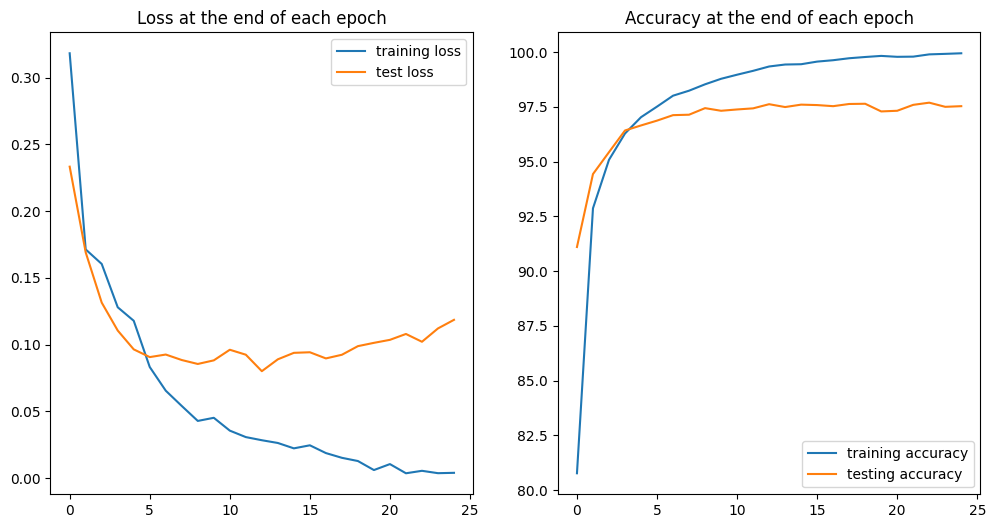

In [19]:
# Plot progression
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].plot(train_losses, label='training loss')
ax[0].plot(test_losses, label='test loss')
ax[0].set_title('Loss at the end of each epoch')
ax[0].legend()

ax[1].plot([t/600 for t in train_correct], label='training accuracy')
ax[1].plot([t/100 for t in test_correct], label='testing accuracy')
ax[1].set_title('Accuracy at the end of each epoch')
ax[1].legend()

### Run evaluation on all test images and store misclassifications

In [27]:
# Initialize arrays for incorrect predictions
incorrect_examples = []
incorrect_labels = []
incorrect_pred = []

all_preds = []
all_targets = []

model.eval()
for b, (data, target) in enumerate(test_loader):
    data , target = data.to(device).view(batch_size_test,-1), target.to(device).view(batch_size_test,-1)
    output = model(data) # shape = torch.Size([batch_size, 10])
    pred = output.argmax(dim=1, keepdim=True) #pred will be a 2d tensor of shape [batch_size,1]
    idxs_mask = ((pred == target.view_as(pred))==False).view(-1)

    # Add misclassifications to list
    incorrect_examples.append(data[idxs_mask].squeeze().cpu().numpy())
    incorrect_labels.append(target[idxs_mask].cpu().numpy()) #the corresponding target to the misclassified image
    incorrect_pred.append(pred[idxs_mask].squeeze().cpu().numpy()) #the corresponiding predicted class of the misclassified image

    all_preds.extend(pred.view_as(target).cpu().numpy())
    all_targets.extend(target.cpu().numpy())

    print('Batch no: ' + str(b) + '\nMisclassifications: ' + str(len(incorrect_labels[b])))

Batch no: 0
Misclassifications: 39
Batch no: 1
Misclassifications: 54
Batch no: 2
Misclassifications: 35
Batch no: 3
Misclassifications: 43
Batch no: 4
Misclassifications: 19
Batch no: 5
Misclassifications: 16
Batch no: 6
Misclassifications: 15
Batch no: 7
Misclassifications: 26


Text(0.5, 1.0, 'True label: 2\nPredicted label: 8')

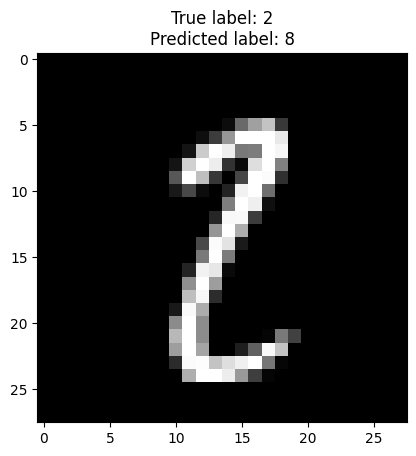

In [28]:
# Showcase misclassified examples

## --- Pick batch and ID --- ##
batchNo = 3
idNo = 2
## ------------------------- ##

# Get image and labels
image = incorrect_examples[batchNo][idNo]
label_true = incorrect_labels[batchNo][idNo][0]
label_pred = incorrect_pred[batchNo][idNo]

# Display
plt.imshow(image.reshape((28,28)), cmap='gray')
plt.title('True label: ' + str(label_true) + '\nPredicted label: ' + str(label_pred))

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(all_targets, all_preds)
cm

array([[ 970,    0,    0,    0,    0,    2,    3,    3,    2,    0],
       [   0, 1119,    4,    2,    1,    1,    2,    1,    5,    0],
       [   5,    0, 1003,    4,    2,    1,    1,    8,    8,    0],
       [   0,    0,    2,  992,    0,    3,    0,    5,    5,    3],
       [   1,    0,    3,    0,  957,    1,    4,    5,    0,   11],
       [   1,    0,    0,   16,    2,  859,    3,    0,    6,    5],
       [   2,    1,    2,    1,    5,    7,  935,    1,    4,    0],
       [   0,    2,    7,    1,    2,    0,    0, 1006,    1,    9],
       [   6,    0,    4,    9,    6,    7,    1,    3,  931,    7],
       [   2,    2,    0,    5,    7,    5,    2,    4,    1,  981]])

In [39]:
class_names = ['Digit 0', 'Digit 1', 'Digit 2', 'Digit 3', 'Digit 4', 
               'Digit 5', 'Digit 6', 'Digit 7', 'Digit 8', 'Digit 9']
report = classification_report(all_targets, all_preds, target_names=class_names)
print(report)

              precision    recall  f1-score   support

     Digit 0       0.98      0.99      0.99       980
     Digit 1       1.00      0.99      0.99      1135
     Digit 2       0.98      0.97      0.98      1032
     Digit 3       0.96      0.98      0.97      1010
     Digit 4       0.97      0.97      0.97       982
     Digit 5       0.97      0.96      0.97       892
     Digit 6       0.98      0.98      0.98       958
     Digit 7       0.97      0.98      0.97      1028
     Digit 8       0.97      0.96      0.96       974
     Digit 9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



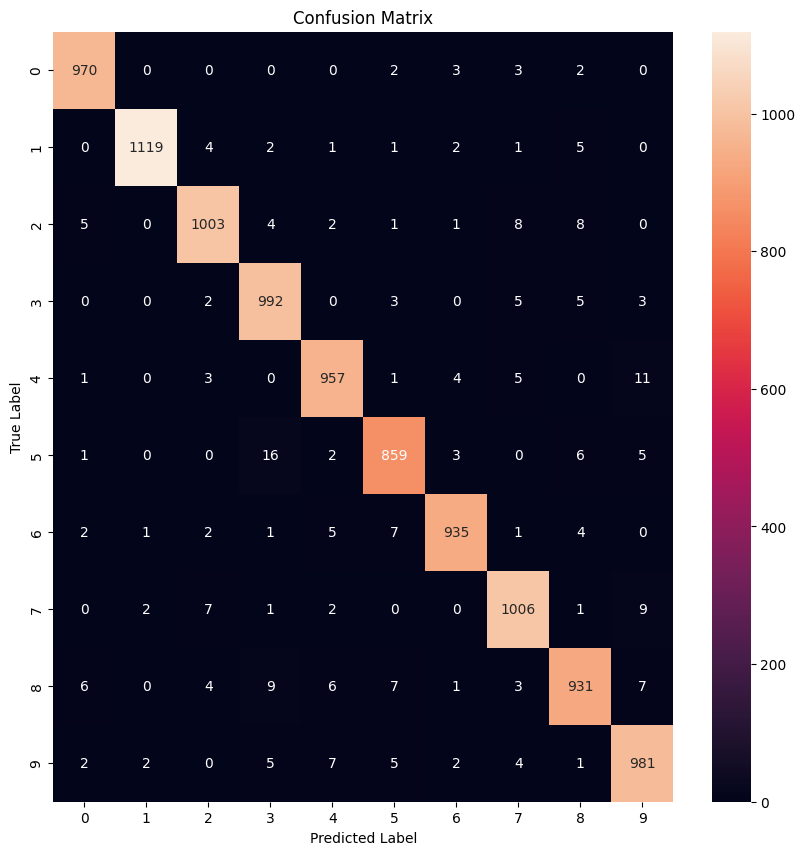

In [40]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()